In [26]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True})

from data.toy_data.hyperbolic import hyperbolic
from data.toy_data.circle import circle
from data.toy_data.spiral import twospirals

from src.diffeomorphisms.iresnet_euclidean_product import i_ResNet_into_Euclidean
from src.manifolds.euclidean import Euclidean
from src.manifolds.pull_back_manifold import PullBackManifold
from src.riemannian_autoencoder import Curvature_Corrected_Riemannian_Autoencoder
from src.riemannian_autoencoder.low_rank_approximation.naive_tsvd import naive_low_rank_approximation
from src.utils.isomap import make_adjacency, get_path, isomap
from src.utils.neural_network.distance_data_set import DistanceData

# set seed
torch.manual_seed(31)

In [27]:
# data parameters
num_data = 51
num_test_data = 500
noise = 0.1
test_noise = 0.5

# iresnet parameters
s_nBlocks = 100 
s_max_iter_inverse = 50
s_int_features = 10 
s_coeff = 0.8 
s_n_power_iter = 10 

# variational problem parameters
alpha_sub = 10.
alpha_iso = 1/100

n_epochs = 20

In [28]:
s_data_manifold = twospirals(int((num_test_data-1)/2), noise=0.)
s_data = twospirals(int((num_data-1)/2), noise=noise)

In [29]:
# load parameters
trained_networks_path = os.path.join("models", "spiral")
# TODO get s_offset and s_orthogonal
s_offset = torch.zeros(2)
s_orthogonal = torch.eye(2)

# construct diffeomorphisms
s_M_dict = {}
figure_label_dict = {}
for i in range(2):
    for j in range(2):
        s_phi_path = os.path.join(trained_networks_path, 
                                  "i_resnet_euclidean_product_{}_blocks_{}_int_features_{}_epochs_{}_subspace_reg_{}_isometry_reg.pt".format(
                                      s_nBlocks, s_int_features, n_epochs, bool(i), bool(j))
                                  )
        s_diffeo = i_ResNet_into_Euclidean([1,1], s_offset, s_orthogonal, 
                          nBlocks=s_nBlocks, max_iter_inverse=s_max_iter_inverse, int_features=s_int_features, coeff=s_coeff, n_power_iter=s_n_power_iter) 
        s_diffeo.phi.load_state_dict(torch.load(s_phi_path))
        s_M_dict[f"{i}{j}"] = PullBackManifold(s_diffeo)
        figure_label_dict[f"{i}{j}"] = r'$\alpha_{\mathrm{sub}}=$' +f'{i * alpha_sub}, ' + r'$\alpha_{\mathrm{iso}}=$' +f'{j * alpha_iso}'

results_path = os.path.join("results")
fig_size = 10


In [30]:
# choose special points
s_z1 = s_data[0][None]
s_z2 = s_data[-1][None]
s_z3 = s_offset
# s_z4 = s_data[20][None]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


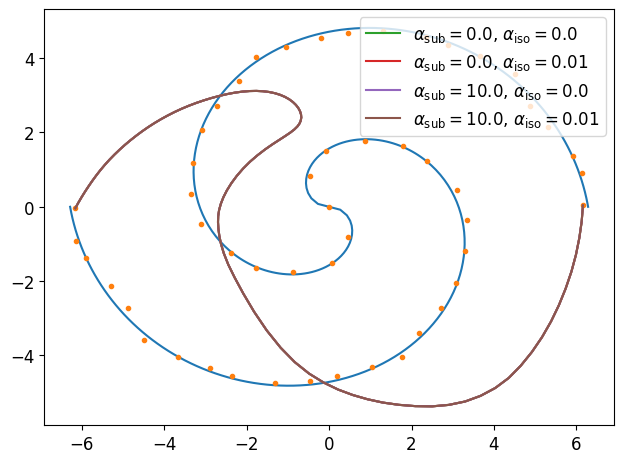

In [31]:
# geodesic interpolation
t = torch.linspace(0,1,100)

# plt.figure(figsize=(fig_size, fig_size))
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]

        # compute geodesics
        s_gamma_12_t =  s_M.geodesic(s_z1, s_z2, t)

        # plot geodesics
        plt.plot(s_gamma_12_t.squeeze().detach().numpy()[:,0], s_gamma_12_t.squeeze().detach().numpy()[:,1], 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.savefig(os.path.join(results_path,f"geodesics_on_s_M.eps"))
plt.show()

/Users/wdiepeveen/Documents/PhD/Projects/10 - Learning Riemannian Geometry/src/article/Pulling-back-symmetric-Riemannian-geometry-for-data-analysis/src/diffeomorphisms/iresnet_euclidean_product.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  return [fwd.T.split([self.d0, self.d1])[0].T, fwd.T.split([self.d0, self.d1])[1].T]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


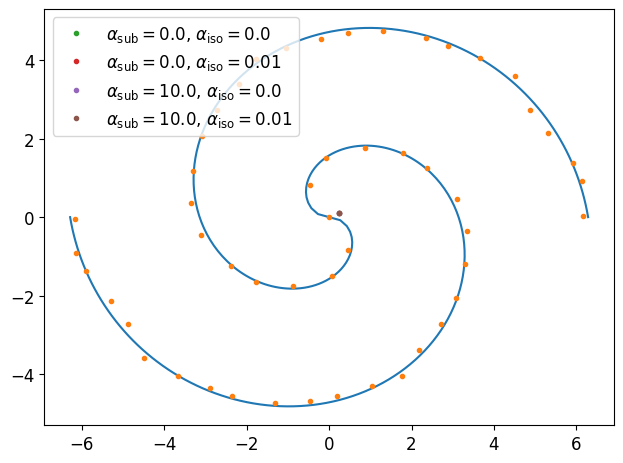

In [32]:
# barycentre
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]
        
        # compute barycentre
        s_barycentre = s_M.barycentre(s_data[None])

        # plot barycentre
        plt.plot(s_barycentre[:,0].detach().numpy(), s_barycentre[:,1].detach().numpy(), '.', label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.savefig(os.path.join(results_path,f"barycentre_on_s_M.eps"))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


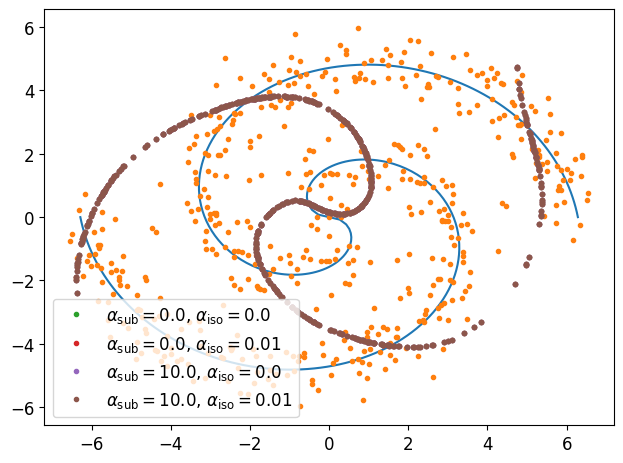

In [33]:
# low rank approximation
noisy_s_data = twospirals(int((num_test_data-1)/2), noise=test_noise) 

plt.plot(noisy_s_data[:,0], noisy_s_data[:,1], '.')
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]

        # compute logs to all data
        s_logs = s_M.log(s_z3 * torch.ones((num_data,1)), s_data[:,None])[:,0]

        # # plot logs TODO plot seperately -- create new figure
        # plt.plot(s_logs.squeeze().detach().numpy()[:,0], s_logs.squeeze().detach().numpy()[:,1], '.', 
        #          label=figure_label_dict[f"{i}{j}"])
        # plt.axis('equal')

        # rank 1 approximation
        s_z = s_barycentre.squeeze()
        s_R_z, s_U = naive_low_rank_approximation(s_M, s_z, s_data, 1)
        s_w_z = s_R_z / s_M.norm(s_z[None], s_R_z[None])[:,None]

        # construct CC-RAE from training data
        s_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(s_M, s_z, s_w_z)

        # project noisy test data onto manifold with RAE
        projected_s_mesh = s_rae_w_z.project_on_manifold(noisy_s_data)

        # plot results
        plt.plot(projected_s_mesh.cpu().detach().numpy()[:,0], projected_s_mesh.cpu().detach().numpy()[:,1], '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.savefig(os.path.join(results_path,f"rae_projections_on_s_M.eps"))
plt.show()